# The next step was to understand the sift in detail by understanding lower-level functions which are used by the core sift functions

Lets start by making a new signal and running the standard sift on the simulation

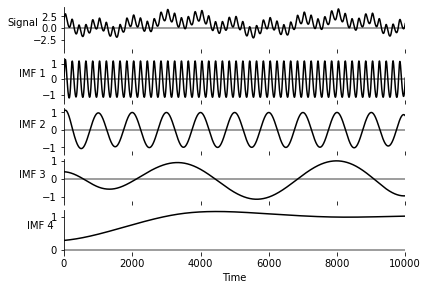

In [3]:
import emd
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1000
seconds = 10
num_samples = sample_rate*seconds
time_vect = np.linspace(0, seconds, num_samples)
freq = 5

# Change extent of deformation from sinusoidal shape [-1 to 1]
nonlinearity_deg = .25

# Change left-right skew of deformation [-pi to pi]
nonlinearity_phi = -np.pi/4

# Create a non-linear oscillation
x = emd.simulate.abreu2010(freq, nonlinearity_deg, nonlinearity_phi, sample_rate, seconds)

x += np.cos(2 * np.pi * 1 * time_vect)        # Add a simple 1Hz sinusoid
x -= np.sin(2 * np.pi * 2.2e-1 * time_vect)   # Add a very slow cycle


config = emd.sift.get_config('sift')
config['imf_opts/sd_thresh'] = 0.05
imf = emd.sift.sift(x)
emd.plotting.plot_imfs(imf)

Internally the `sift` function calls a set of lower level functions to extract the IMFs. These functions are call in a hierarchy when you run `sift` it will call `get_next_imf` behind the scenes. Similarly, `get_next_imf` makes use of `interp_envelope` and so on.

- `get_next_imf` extracts the fastest IMF from an input signal
- `interp_envelope` find the interpolated envelope of a signal.
- `get_padded_extrema` identifies the location and magnitude of signal extrema with optional padding.

# IMF Extraction 
Here we call ``get_next_imf`` repeatedly on a signal and its residuals to
implement a very simple sift. We extract the first IMF, subtract it from the
data and then extract the second and third IMFs. We then plot the original
signal, the IMFs and the residual.


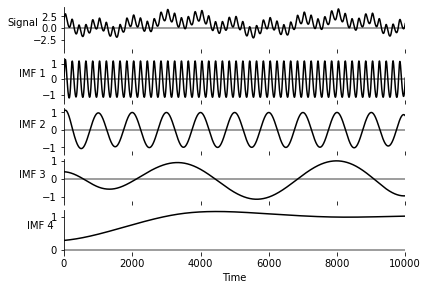

In [5]:
# Extract the options for get_next_imf - these can be customised here at this point.
imf_opts = config['imf_opts']

# Extract first IMF from the signal
imf1, continue_sift = emd.sift.get_next_imf(x[:, None],           **imf_opts)

# Extract second IMF from the signal with the first IMF removed
imf2, continue_sift = emd.sift.get_next_imf(x[:, None]-imf1,      **imf_opts)

# Extract third IMF from the signal with the first and second IMFs removed
imf3, continue_sift = emd.sift.get_next_imf(x[:, None]-imf1-imf2, **imf_opts)

# The residual is the signal component left after removing the IMFs
residual = x[:, None] - imf1 - imf2 - imf3

imfs_manual = np.c_[imf1, imf2, imf3, residual]
emd.plotting.plot_imfs(imfs_manual)